In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# File paths
file1 = '/Users/marclambertes/Python/LIVXG.xlsx'
file2 = '/Users/marclambertes/xA.xlsx'
file3 = '/Users/marclambertes/xT.xlsx'

# Load each Excel file into a DataFrame
df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)
df3 = pd.read_excel(file3)

# Combine all files into a single DataFrame
df = pd.concat([df1, df2, df3], ignore_index=True)

# Rename 'Total' column to 'xT' if necessary
df = df.rename(columns={'Total': 'xT'})

# Define weights
w_xG = 0.5
w_xA = 0.3
w_xT = 0.2

# Calculate weighted scores for each action type
df['Shooting_Score'] = df['xG'] * w_xG
df['Passing_Score'] = df['xA'] * w_xA
df['Progressive_Score'] = df['xT'] * w_xT

# Calculate combined score by summing the weighted scores
df['Combined_Score'] = df['Shooting_Score'] + df['Passing_Score'] + df['Progressive_Score']

# Apply log transformation to Combined_Score to reduce the effect of outliers
# We add a small constant to avoid taking the log of zero or negative numbers
df['Log_Combined_Score'] = np.log1p(df['Combined_Score'])

# Normalize the log-transformed scores to a 0-100 scale
scaler = MinMaxScaler(feature_range=(0, 100))
df['Normalized_Combined_Score'] = scaler.fit_transform(df[['Log_Combined_Score']])

# Optionally, group by PlayerId and TeamId to get total combined scores and normalized score
player_scores = df.groupby(['PlayerId', 'TeamId'])[['Shooting_Score', 'Passing_Score', 'Progressive_Score', 'Combined_Score', 'Normalized_Combined_Score']].sum().reset_index()

# Save the player_scores DataFrame to an Excel file
output_file = '/Users/marclambertes/Python/player_scores_with_normalized_combined_scores.xlsx'
player_scores.to_excel(output_file, index=False)

# Print a message confirming that the file was saved
print(f"Player scores with normalized combined scores saved to {output_file}")


Player scores with normalized combined scores saved to /Users/marclambertes/Python/player_scores_with_normalized_combined_scores.xlsx


In [7]:
player_scores

,PlayerId,TeamId,Shooting_Score,Passing_Score,Progressive_Score,Combined_Score,Normalized_Combined_Score
0,A. Diallo,Manchester United FC,0.016358,0.000000,0.0668,0.033400,17.016583
1,A. Elanga,Nottingham Forest FC,0.193087,0.000000,0.0024,0.001200,7.276666
2,A. Garnacho,Manchester United FC,0.000000,0.000000,-0.0108,-0.005400,5.241637
3,A. Mac Allister,Liverpool FC,0.428845,0.120556,0.2612,0.523414,218.385263
4,A. Onana,Manchester United FC,0.000000,0.000000,0.0108,0.005400,8.564712
...,...,...,...,...,...,...,...
156,W. Burns,Ipswich Town FC,0.000000,0.000000,-0.0056,-0.002800,6.044923
157,W. Endō,Liverpool FC,0.000000,0.000000,0.0000,0.000000,20.722785
158,W. Hughes,Crystal Palace FC,0.025078,0.000000,0.0088,0.004400,8.258523
159,Y. Wissa,Brentford FC,0.000000,0.000000,0.0020,0.001000,7.215196


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Player data not found.


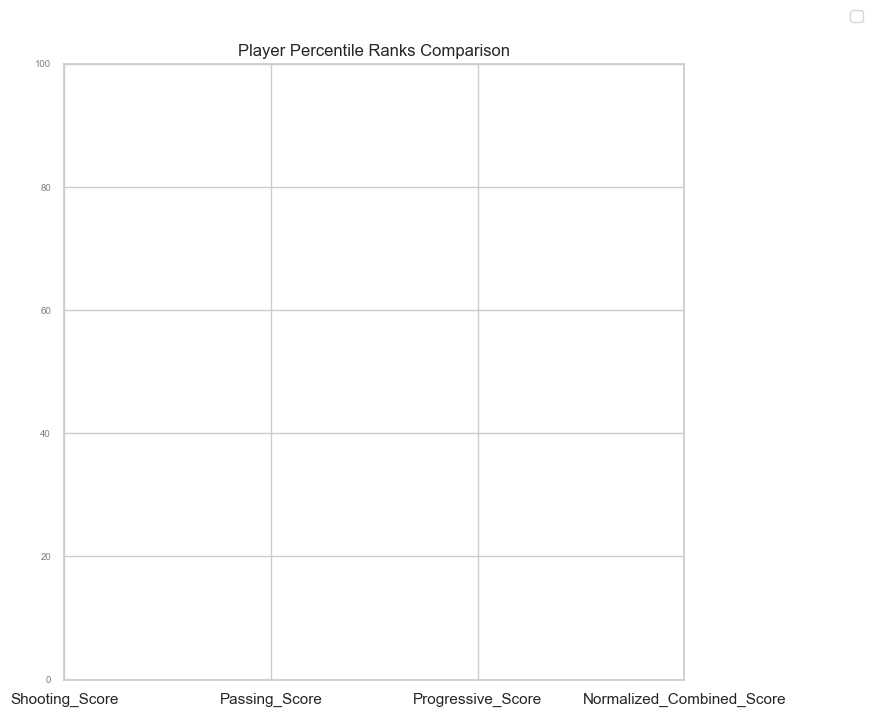

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the player_scores data from the Excel file
file_path = '/Users/marclambertes/Python/player_scores_with_normalized_combined_scores.xlsx'
player_scores = pd.read_excel(file_path)

# Calculate percentile ranks for each score column
score_columns = ['Shooting_Score', 'Passing_Score', 'Progressive_Score', 'Normalized_Combined_Score']
for col in score_columns:
    player_scores[f'{col}_Percentile'] = player_scores[col].rank(pct=True) * 100

# Set up a plot style
sns.set(style="whitegrid")

# Example 1: Bar Plot of Percentile Ranks for a Specific Player
# Replace 'PlayerId' and 'TeamId' with actual values of a player you want to visualize
player_id = 1
team_id = 1
player_data = player_scores[(player_scores['PlayerId'] == player_id) & (player_scores['TeamId'] == team_id)]

if not player_data.empty:
    # Extract percentile rank values
    percentiles = player_data[[f'{col}_Percentile' for col in score_columns]].values.flatten()
    
    # Bar plot
    plt.figure(figsize=(8, 5))
    plt.bar(score_columns, percentiles, color='skyblue')
    plt.ylim(0, 100)
    plt.title(f'Percentile Ranks for Player {player_id} (Team {team_id})')
    plt.ylabel('Percentile Rank')
    plt.xlabel('Score Type')
    plt.show()
else:
    print("Player data not found.")

# Example 2: Radar Chart for Multiple Players
from math import pi

# Select a few players for radar chart visualization
players_to_compare = player_scores[player_scores['PlayerId'].isin([1, 2, 3])]  # Replace with actual PlayerIds
categories = [f'{col}_Percentile' for col in score_columns]

# Radar chart setup
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Plot each player on the radar chart
plt.figure(figsize=(8, 8))
for i, row in players_to_compare.iterrows():
    values = row[categories].tolist()
    values += values[:1]  # Complete the loop
    
    plt.polar(angles, values, label=f"Player {row['PlayerId']} (Team {row['TeamId']})")
    plt.fill(angles, values, alpha=0.25)

plt.title('Player Percentile Ranks Comparison')
plt.xticks(angles[:-1], score_columns)
plt.yticks(range(0, 101, 20), color="grey", size=7)
plt.ylim(0, 100)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()
